## LIDAR to 2D grid map example

This simple tutorial shows how to read LIDAR (range) measurements from a file and convert it to occupancy grid.

Occupancy grid maps (_Hans Moravec, A.E. Elfes: High resolution maps from wide angle sonar, Proc. IEEE Int. Conf. Robotics Autom. (1985)_) are a popular, probabilistic approach to represent the environment. The grid is basically discrete representation of the environment, which shows if a grid cell is occupied or not. Here the map is represented as a `numpy array`, and numbers close to 1 means the cell is occupied (_marked with red on the next image_), numbers close to 0 means they are free (_marked with green_). The grid has the ability to represent unknown (unobserved) areas, which are close to 0.5.

![Example](grid_map_example.png)


In order to construct the grid map from the measurement we need to discretise the values. But, first let's need to `import` some necessary packages.

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, radians, pi

The measurement file contains the distances and the corresponding angles in a `csv` (comma separated values) format. Let's write the `file_read` method:

In [2]:
def file_read(f):
    """
    Reading LIDAR laser beams (angles and corresponding distance data)
    """
    measures = [line.split(",") for line in open(f)]
    angles = []
    distances = []
    for measure in measures:
        angles.append(float(measure[0]))
        distances.append(float(measure[1]))
    angles = np.array(angles)
    distances = np.array(distances)
    return angles, distances

From the distances and the angles it is easy to determine the `x` and `y` coordinates with `sin` and `cos`. 
In order to display it `matplotlib.pyplot` (`plt`) is used.

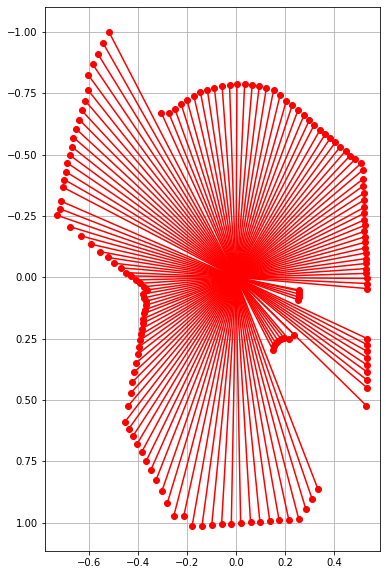

In [3]:
ang, dist = file_read("lidar01.csv")
ox = np.sin(ang) * dist
oy = np.cos(ang) * dist
plt.figure(figsize=(6,10))
plt.plot([oy, np.zeros(np.size(oy))], [ox, np.zeros(np.size(oy))], "ro-") # lines from 0,0 to the 
plt.axis("equal")
bottom, top = plt.ylim()  # return the current ylim
plt.ylim((top, bottom)) # rescale y axis, to match the grid orientation
plt.grid(True)
plt.show()

The `lidar_to_grid_map.py` contains handy functions which can used to convert a 2D range measurement to a grid map. For example the `bresenham`  gives the a straight line between two points in a grid map. Let's see how this works.

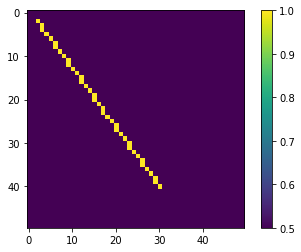

In [3]:
import lidar_to_grid_map as lg
map1 = np.ones((50, 50)) * 0.5
line = lg.bresenham((2, 2), (40, 30))
for l in line:
    map1[l[0]][l[1]] = 1
plt.imshow(map1)
plt.colorbar()
plt.show()

In [4]:
line

array([[ 2,  2],
       [ 3,  3],
       [ 4,  3],
       [ 5,  4],
       [ 6,  5],
       [ 7,  6],
       [ 8,  6],
       [ 9,  7],
       [10,  8],
       [11,  9],
       [12,  9],
       [13, 10],
       [14, 11],
       [15, 12],
       [16, 12],
       [17, 13],
       [18, 14],
       [19, 15],
       [20, 15],
       [21, 16],
       [22, 17],
       [23, 17],
       [24, 18],
       [25, 19],
       [26, 20],
       [27, 20],
       [28, 21],
       [29, 22],
       [30, 23],
       [31, 23],
       [32, 24],
       [33, 25],
       [34, 26],
       [35, 26],
       [36, 27],
       [37, 28],
       [38, 29],
       [39, 29],
       [40, 30]])

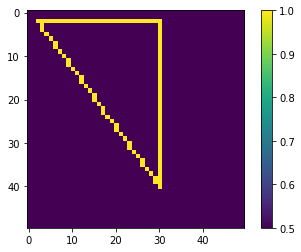

In [6]:
line = lg.bresenham((2, 30), (40, 30))
for l in line:
    map1[l[0]][l[1]] = 1
line = lg.bresenham((2, 30), (2, 2))
for l in line:
    map1[l[0]][l[1]] = 1
plt.imshow(map1)
plt.colorbar()
plt.show()

To fill empty areas, a queue-based algorithm can be used that can be used on an initialized occupancy map. The center point is given: the algorithm checks for neighbour elements in each iteration, and stops expansion on obstacles and free boundaries.

In [7]:
from collections import deque
def flood_fill(cpoint, pmap):
    """
    cpoint: starting point (x,y) of fill
    pmap: occupancy map generated from Bresenham ray-tracing
    """
    # Fill empty areas with queue method
    sx, sy = pmap.shape
    fringe = deque()
    fringe.appendleft(cpoint)
    while fringe:
        n = fringe.pop()
        nx, ny = n
        # West
        if nx > 0:
            if pmap[nx - 1, ny] == 0.5:
                pmap[nx - 1, ny] = 0.0
                fringe.appendleft((nx - 1, ny))
        # East
        if nx < sx - 1:
            if pmap[nx + 1, ny] == 0.5:
                pmap[nx + 1, ny] = 0.0
                fringe.appendleft((nx + 1, ny))
        # North
        if ny > 0:
            if pmap[nx, ny - 1] == 0.5:
                pmap[nx, ny - 1] = 0.0
                fringe.appendleft((nx, ny - 1))
        # South
        if ny < sy - 1:
            if pmap[nx, ny + 1] == 0.5:
                pmap[nx, ny + 1] = 0.0
                fringe.appendleft((nx, ny + 1))

This algotihm will fill the area bounded by the yellow lines starting from a center point (e.g. (10, 20)) with zeros:

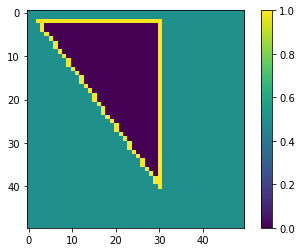

In [8]:
flood_fill((10, 20), map1)
map_float = np.array(map1)/10.0
plt.imshow(map1)
plt.colorbar()
plt.show()

Let's use this flood fill on real data:

The grid map is  150 x 100 .


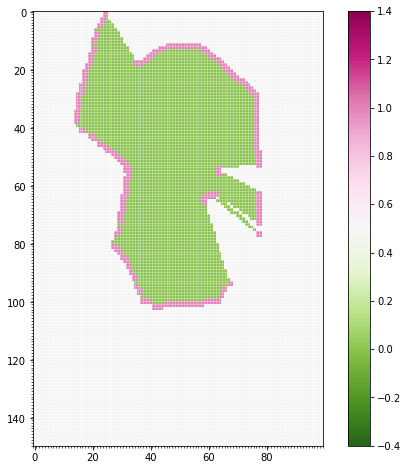

In [9]:
xyreso = 0.02  # x-y grid resolution
yawreso = math.radians(3.1)  # yaw angle resolution [rad]
ang, dist = file_read("lidar01.csv")
ox = np.sin(ang) * dist
oy = np.cos(ang) * dist
pmap, minx, maxx, miny, maxy, xyreso = lg.generate_ray_casting_grid_map(ox, oy, xyreso, False)
xyres = np.array(pmap).shape
plt.figure(figsize=(20,8))
plt.subplot(122)
plt.imshow(pmap, cmap = "PiYG_r") 
plt.clim(-0.4, 1.4)
plt.gca().set_xticks(np.arange(-.5, xyres[1], 1), minor = True)
plt.gca().set_yticks(np.arange(-.5, xyres[0], 1), minor = True)
plt.grid(True, which="minor", color="w", linewidth = .6, alpha = 0.5)
plt.colorbar()
plt.show()

In [23]:
"""
Grid based sweep planner

author: Atsushi Sakai
"""

import math
import os
import sys
from enum import IntEnum

import matplotlib.pyplot as plt
import numpy as np

#sys.path.append(os.path.relpath("../../Mapping/grid_map_lib/"))
try:
    from grid_map_lib import GridMap
except ImportError:
    raise

do_animation = False


class SweepSearcher:
    class SweepDirection(IntEnum):
        UP = 1
        DOWN = -1

    class MovingDirection(IntEnum):
        RIGHT = 1
        LEFT = -1

    def __init__(self, mdirection, sdirection, xinds_goaly, goaly):
        self.moving_direction = mdirection
        self.sweep_direction = sdirection
        self.turing_window = []
        self.update_turning_window()
        self.xinds_goaly = xinds_goaly
        self.goaly = goaly

    def move_target_grid(self, cxind, cyind, gmap):
        nxind = self.moving_direction + cxind
        nyind = cyind

        # found safe grid
        if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
            return nxind, nyind
        else:  # occupided
            ncxind, ncyind = self.find_safe_turning_grid(cxind, cyind, gmap)
            if (ncxind is None) and (ncyind is None):
                # moving backward
                ncxind = -self.moving_direction + cxind
                ncyind = cyind
                if gmap.check_occupied_from_xy_index(ncxind, ncyind):
                    # moved backward, but the grid is occupied by obstacle
                    return None, None
            else:
                # keep moving until end
                while not gmap.check_occupied_from_xy_index(ncxind + self.moving_direction, ncyind, occupied_val=0.5):
                    ncxind += self.moving_direction
                self.swap_moving_direction()
            return ncxind, ncyind

    def find_safe_turning_grid(self, cxind, cyind, gmap):

        for (dxind, dyind) in self.turing_window:

            nxind = dxind + cxind
            nyind = dyind + cyind

            # found safe grid
            if not gmap.check_occupied_from_xy_index(nxind, nyind, occupied_val=0.5):
                return nxind, nyind

        return None, None

    def is_search_done(self, gmap):
        for ix in self.xinds_goaly:
            if not gmap.check_occupied_from_xy_index(ix, self.goaly, occupied_val=0.5):
                return False

        # all lower grid is occupied
        return True

    def update_turning_window(self):
        self.turing_window = [
            (self.moving_direction, 0.0),
            (self.moving_direction, self.sweep_direction),
            (0, self.sweep_direction),
            (-self.moving_direction, self.sweep_direction),
        ]

    def swap_moving_direction(self):
        self.moving_direction *= -1
        self.update_turning_window()

    def search_start_grid(self, grid_map):
        xinds = []
        y_ind = 0
        if self.sweep_direction == self.SweepDirection.DOWN:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
        elif self.sweep_direction == self.SweepDirection.UP:
            xinds, y_ind = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

        if self.moving_direction == self.MovingDirection.RIGHT:
            return min(xinds), y_ind
        elif self.moving_direction == self.MovingDirection.LEFT:
            return max(xinds), y_ind

        raise ValueError("self.moving direction is invalid ")


def find_sweep_direction_and_start_posi(ox, oy):
    # find sweep_direction
    max_dist = 0.0
    vec = [0.0, 0.0]
    sweep_start_pos = [0.0, 0.0]
    for i in range(len(ox) - 1):
        dx = ox[i + 1] - ox[i]
        dy = oy[i + 1] - oy[i]
        d = np.sqrt(dx ** 2 + dy ** 2)

        if d > max_dist:
            max_dist = d
            vec = [dx, dy]
            sweep_start_pos = [ox[i], oy[i]]

    return vec, sweep_start_pos


def convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi):
    tx = [ix - sweep_start_posi[0] for ix in ox]
    ty = [iy - sweep_start_posi[1] for iy in oy]

    th = math.atan2(sweep_vec[1], sweep_vec[0])

    c = np.cos(-th)
    s = np.sin(-th)

    rx = [ix * c - iy * s for (ix, iy) in zip(tx, ty)]
    ry = [ix * s + iy * c for (ix, iy) in zip(tx, ty)]

    return rx, ry


def convert_global_coordinate(x, y, sweep_vec, sweep_start_posi):
    th = math.atan2(sweep_vec[1], sweep_vec[0])
    c = np.cos(th)
    s = np.sin(th)

    tx = [ix * c - iy * s for (ix, iy) in zip(x, y)]
    ty = [ix * s + iy * c for (ix, iy) in zip(x, y)]

    rx = [ix + sweep_start_posi[0] for ix in tx]
    ry = [iy + sweep_start_posi[1] for iy in ty]

    return rx, ry


def search_free_grid_index_at_edge_y(grid_map, from_upper=False):
    yind = None
    xinds = []

    if from_upper:
        xrange = range(grid_map.height)[::-1]
        yrange = range(grid_map.width)[::-1]
    else:
        xrange = range(grid_map.height)
        yrange = range(grid_map.width)

    for iy in xrange:
        for ix in yrange:
            if not grid_map.check_occupied_from_xy_index(ix, iy):
                yind = iy
                xinds.append(ix)
        if yind:
            break

    return xinds, yind


def setup_grid_map(ox, oy, reso, sweep_direction, offset_grid=10):
    width = math.ceil((max(ox) - min(ox)) / reso) + offset_grid
    height = math.ceil((max(oy) - min(oy)) / reso) + offset_grid
    center_x = np.mean(ox)
    center_y = np.mean(oy)

    grid_map = GridMap(width, height, reso, center_x, center_y)

    grid_map.set_value_from_polygon(ox, oy, 1.0, inside=False)

    grid_map.expand_grid()

    xinds_goaly = []
    goaly = 0
    if sweep_direction == SweepSearcher.SweepDirection.UP:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=True)
    elif sweep_direction == SweepSearcher.SweepDirection.DOWN:
        xinds_goaly, goaly = search_free_grid_index_at_edge_y(grid_map, from_upper=False)

    return grid_map, xinds_goaly, goaly


def sweep_path_search(sweep_searcher, gmap, grid_search_animation=False):
    # search start grid
    cxind, cyind = sweep_searcher.search_start_grid(gmap)
    if not gmap.set_value_from_xy_index(cxind, cyind, 0.5):
        print("Cannot find start grid")
        return [], []

    x, y = gmap.calc_grid_central_xy_position_from_xy_index(cxind, cyind)
    px, py = [x], [y]

    if grid_search_animation:
        fig, ax = plt.subplots()

    while True:
        cxind, cyind = sweep_searcher.move_target_grid(cxind, cyind, gmap)

        if sweep_searcher.is_search_done(gmap) or (cxind is None or cyind is None):
            print("Done")
            break

        x, y = gmap.calc_grid_central_xy_position_from_xy_index(
            cxind, cyind)

        px.append(x)
        py.append(y)

        gmap.set_value_from_xy_index(cxind, cyind, 0.5)

        if grid_search_animation:
            gmap.plot_grid_map(ax=ax)
            plt.pause(1.0)

    gmap.plot_grid_map()

    return px, py


def planning(ox, oy, reso,
             moving_direction=SweepSearcher.MovingDirection.RIGHT,
             sweeping_direction=SweepSearcher.SweepDirection.UP,
             ):
    sweep_vec, sweep_start_posi = find_sweep_direction_and_start_posi(ox, oy)

    rox, roy = convert_grid_coordinate(ox, oy, sweep_vec, sweep_start_posi)

    gmap, xinds_goaly, goaly = setup_grid_map(rox, roy, reso, sweeping_direction)

    sweep_searcher = SweepSearcher(moving_direction, sweeping_direction, xinds_goaly, goaly)

    px, py = sweep_path_search(sweep_searcher, gmap)

    rx, ry = convert_global_coordinate(px, py, sweep_vec, sweep_start_posi)

    print("Path length:", len(rx))

    return rx, ry


def planning_animation(ox, oy, reso):  # pragma: no cover
    px, py = planning(ox, oy, reso)

    # animation
    if do_animation:
        for ipx, ipy in zip(px, py):
            plt.cla()
            plt.plot(ox, oy, "-xb")
            plt.plot(px, py, "-r")
            plt.plot(ipx, ipy, "or")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.1)

    plt.cla()
    plt.plot(ox, oy, "-xb")
    plt.plot(px[:2], py[:2], "-r")
    plt.axis("equal")
    plt.grid(True)
    plt.pause(0.1)
    print("px ", px)
    print("py ", py)


def main():  # pragma: no cover
    print("start!!")

    ox = [10.0, 25.0, 50.0, 100.0, 130.0, 40.0, 10.0]
    oy = [10.0, -20.0, 0.0, 30.0, 60.0, 80.0, 10.0]
    reso = 5.0
    planning_animation(ox, oy, reso)

#     ox = [0.0, 50.0, 50.0, 0.0, 0.0]
#     oy = [0.0, 0.0, 30.0, 30.0, 0.0]
#     reso = 1.3
#     planning_animation(ox, oy, reso)

#     ox = [0.0, 20.0, 50.0, 200.0, 130.0, 40.0, 0.0]
#     oy = [0.0, -80.0, 0.0, 30.0, 60.0, 80.0, 0.0]
#     reso = 5.0
#     planning_animation(ox, oy, reso)

    plt.show()

    print("done!!")


# if __name__ == '__main__':
#     main()

start!!
Done
Path length: 182


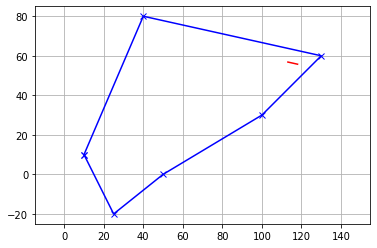

px  [118.03548370527396, 113.15454840435419, 108.27361310343443, 103.39267780251467, 98.51174250159491, 93.63080720067514, 88.74987189975538, 83.8689365988356, 78.98800129791584, 74.10706599699608, 69.22613069607632, 64.34519539515657, 59.464260094236806, 54.58332479331703, 49.70238949239727, 44.821454191477514, 43.73680190238423, 48.61773720330399, 53.49867250422375, 58.37960780514352, 63.26054310606328, 68.14147840698304, 73.02241370790281, 77.90334900882257, 82.78428430974233, 87.66521961066209, 92.54615491158185, 97.42709021250162, 102.30802551342138, 107.18896081434116, 112.06989611526092, 110.98524382616763, 106.10430852524787, 101.2233732243281, 96.34243792340834, 91.46150262248858, 86.58056732156882, 81.69963202064905, 76.81869671972927, 71.93776141880952, 67.05682611788976, 62.175890816969996, 57.29495551605024, 52.41402021513046, 47.533084914210704, 42.652149613290945, 36.68656202327789, 41.56749732419766, 46.44843262511742, 51.32936792603718, 56.21030322695695, 61.0912385278

In [24]:
main()